# Computing p-values and converting them to a significance

**Author:**  Matthew Kenzie ([matthew.kenzie@cern.ch](mailto:matthew.kenzie@cern.ch)) <br>
**Updated:** 17th Feb 2021

This notebook tries to cover common methods for computing p-values and then how to handle their conversion to a significance. 

In the examples I have come across in HEP p-values seems to be computed in a few different ways, either using 

 1.  an asymptotic assumption and/or Wilks' theorem (i.e. the posterior PDF is Gaussian or the $-2\Delta\ln L$ is distributed like a $\chi^2$ 
 2.  generating toys representing the null hypothesis (e.g. background only) and then computing the p-value as the fraction of toys that fulfill some requirement (this can be the fraction with a larger / smaller parameter value than the one found in data or it can be the fraction with a larger $-2\Delta\ln L$ 
 
If you have an example case you would like added to these tests then please [get in touch](mailto:matthew.kenzie@cern.ch).
 
There is then some debate about whether the conversion from p-value to significance should be one-sided or two-sided (I think there is also confusion about what one-sided and two-sided mean so I define what *I mean* by them below). 

There is one additional caveat worth mentioning which is that when computing the test-statistic (usally a log-likelihood ratio), parameter limits are important. For example it is common in Higgs searches to define the test-statistic as the log-likelihood ratio when the fitted signal is positive and zero otherwise. This means a large fraction of the toys (50%) will have a test-statisics value of zero.

### A **one-sided conversion** 
 - assumes the conversion to significance by only integrating one side of the Gaussian distribution (see plot below).
 - This is commonly used in searches for new resonances (e.g. Higgs) and is the recommendation of the PDG (see Eq. (40.45) and Eq. (40.46) of the [PDG 2020 Statistics Chapter](https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf)) and states

 $Z = \Phi^{-1}(1-p)$,
 
 where $\Phi$ is the cummalative distribution of a unit Gaussian and $\Phi^{-1}$ its inverse, often called the quantile or "percentage point", function
 - Some common tools used to convert a p-value in this way are
    - `scipy.stats.norm.ppf(1-p)`
    - `ROOT.RooStats.PValueToSignificance(1-p)`
    - `scipy.stats.chi2.ppf(1-2*p,1)**0.5`

### A **two-sided conversion**
 - assumes the conversion to significance by considering the p-value as containing both sides of the Gaussian (see plot below)
 - This is commonly used under the toy generation method when computing the p-value as the fraction of toys with a worse $-2\Delta\ln L$ than the data (this is because the $\ln L$ symmetrises the distribution and thus contains both sides of the Gaussian)
 - Some common tools used to convert a p-value in this way are
    - `scipy.stats.norm.ppf(1-p/2)`
    - `ROOT.TMath.ChisquareQuantile(1-p,1)**0.5`
    - `scipy.stats.chi2.ppf(1-p,1)**0.5`

## A simple example

We will assume that the null hypothesis is distributed itself as a unit Gaussian (this could be the value of some physics parameter, $x$, we are fitting for under the SM expectation) and let's say our observation in data is at 3.

It seems rather obvious in this case that our <font color=red>significance should be $3\sigma$</font>.

Our p-value is the integral from the observed point to infinity of the distribution

$p = \int_{obs}^{\infty} f(x) dx$,

where in this case $f(x)$ is the unit Gaussian.

pvalue = 0.0013498980316301035


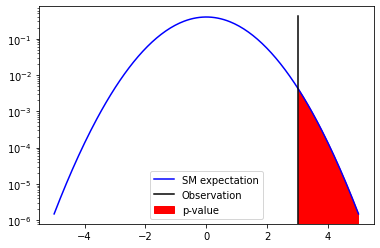

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

sm_exp = norm(0,1)
data_obs = 3

x = np.linspace(-5,5,200)
plt.plot(x,sm_exp.pdf(x), 'b-', label='SM expectation')
plt.fill_between(x[x>data_obs], 0, sm_exp.pdf(x[x>data_obs]), color='r', label='p-value')
plt.plot((data_obs,data_obs), (0,plt.ylim()[1]), 'k-', label='Observation')
plt.legend()
plt.yscale('log')

pval = 1 - sm_exp.cdf(data_obs)
print(f'pvalue = {pval}')

This gives a p-value of 0.0013 which we can now convert to a significance using our two conversions above

In [2]:
sigma_1side = chi2.ppf(1-2*pval,1)**0.5
sigma_2side = chi2.ppf(1-pval,1)**0.5

print('sigma (1-side):', sigma_1side)
print('sigma (2-side):', sigma_2side)

sigma (1-side): 2.999999999999998
sigma (2-side): 3.205154920598932


Cleary in this case **using a two-sided conversion is wrong**

### An alternative using the posterior PDF

Sometimes people use the posterior PDF of their observation and test the compatiblity with the null hypothesis to compute a p-value which is a slightly different method. In this simple case it equates to largely the same thing.

Let's say now our best fit observation is $3\pm 1$, so our posterior pdf is a Gaussian with unit width centered at 3. We can now ask what the p-value is at the SM expectation of zero. This will give identical results to the above in this simple case.

## Computing the p-value from a likelihood fit (and maybe generating toys)

This seems to be a much more common method. Typically in particle physics we are using a likelihood fit to extract our parameters of interest.

We can extend the example above to incorporate the likelihood fit case (which in reality will of course be much more complicated that the pedagogical example given here)

1. Let's mock up a "likelihood fit" to our data. 
   - In this case (we don't actually have to run the fit here because we already know where the minimum is - at our observed value).
   - We can then use a simple evaluation of the significance as $\sqrt{-2\Delta\ln L} = 3\sigma$


In [3]:
data_obs = (3,1)
sm_val = 0

def nll(exp, obsval, obserr):
    n = norm(obsval, obserr)
    return -2*n.logpdf(exp)

### So the DLL in Data is
data_dll = nll(sm_val, data_obs[0], data_obs[1]) - nll(data_obs[0], data_obs[0], data_obs[1])
print('DLL in Data: ', data_dll)
print('Significance:', data_dll**0.5)

DLL in Data:  9.0
Significance: 3.0


2. Let's also try running some toys and computing the DLL for those
   - We may be concerned that our likelihood doesn't suitably follow the $\chi^2$ distribution so we may instead choose to generate toys and then compute the p-value from the fraction which perform worse than the data

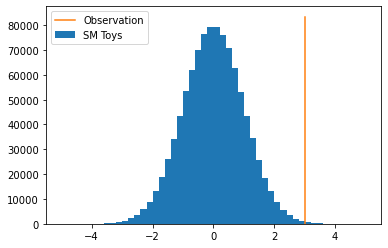

In [4]:
### Generate toys from the SM distribution
sm_toys = sm_exp.rvs(size=1000000)

### Can plot this distribution with the data observation
plt.hist( sm_toys, range=(-5,5), bins=50, label='SM Toys')
plt.plot( (data_obs[0],data_obs[0]), (0,plt.ylim()[1]), label='Observation' )
plt.legend()

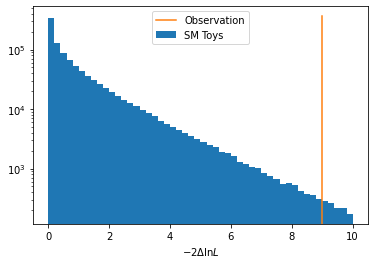

In [5]:
### Now for each toy we compute the DLL between the toy value and the SM expectation
toy_dlls = nll( sm_val, sm_toys, data_obs[1] ) - nll(sm_toys, sm_toys, data_obs[1])

## And we can also now plot these
plt.hist( toy_dlls, range=(0,10), bins=50, label='SM Toys')
plt.plot( (data_dll,data_dll), (0,plt.ylim()[1]), label='Observation')
plt.xlabel('$-2\Delta\ln L$')
plt.legend()
plt.yscale('log')

In [6]:
### Now count the fraction of toys above the DLL value in data (this is the p-value)
pval = len(toy_dlls[toy_dlls>data_dll])/len(toy_dlls)
pval_err = (pval * (1-pval)/len(toy_dlls))**0.5

print(f'p-value = {pval} +/- {pval_err}')

p-value = 0.002677 +/- 5.1670433237974695e-05


Notice **this p-value is not the same as the one we computed before**. 

Infact it's twice as large because now the symmetry of the DLL gives us both sides of the distribution. Perhaps you can see where this is going if we now compute the significances using the two conversions above.

In [7]:
sigma_1side = chi2.ppf(1-2*pval,1)**0.5
sigma_2side = chi2.ppf(1-pval,1)**0.5

print('sigma (1-side):', sigma_1side)
print('sigma (2-side):', sigma_2side)

sigma (1-side): 2.784925638563386
sigma (2-side): 3.002581821796763


Cleary in this case **using a one-sided conversion is wrong**

3. Just for completeness we can repeat this computation the way it is done in many searches in which the test-statistic is set to zero if the fitted signal yield is negative
    - We can use the same toys and the same DLL values but now for any toys which are <0 we set the DLL=0

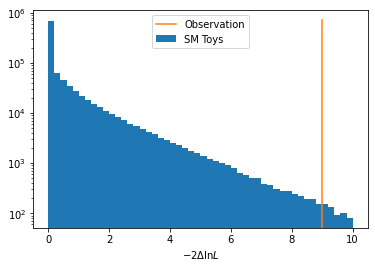

In [8]:
### Now for only positive toys we compute the DLL between the toy value and the SM expectation
toy_dlls = nll( sm_val, sm_toys[sm_toys>=0], data_obs[1] ) - nll(sm_toys[sm_toys>=0], sm_toys[sm_toys>=0], data_obs[1])

### For all negative toys we just add a DLL value of 0
toy_dlls = np.concatenate( [toy_dlls, np.zeros( len(sm_toys[sm_toys<0]))] )

## And we can also now plot these
plt.hist( toy_dlls, range=(0,10), bins=50, label='SM Toys')
plt.plot( (data_dll,data_dll), (0,plt.ylim()[1]), label='Observation')
plt.xlabel('$-2\Delta\ln L$')
plt.legend()
plt.yscale('log')

In [9]:
### Now count the fraction of these toys above the DLL value in data (this is the p-value)
pval = len(toy_dlls[toy_dlls>data_dll])/len(toy_dlls)
pval_err = (pval * (1-pval)/len(toy_dlls))**0.5

print(f'p-value = {pval} +/- {pval_err}')

p-value = 0.001333 +/- 3.6485930315670997e-05


Now you can see **this p-value is again the same as the one we got originally** (by which I mean the p-value we got from just integrating the null-hypothesis PDF from the observation up to infinity)

And so in this case we again need **a one-sided conversion**

In [10]:
sigma_1side = chi2.ppf(1-2*pval,1)**0.5
sigma_2side = chi2.ppf(1-pval,1)**0.5

print('sigma (1-side):', sigma_1side)
print('sigma (2-side):', sigma_2side)

sigma (1-side): 3.003834847228135
sigma (2-side): 3.208778804550957


# Summary

I believe the conversion from a p-value to a significance is **more than just convention**. The conversion you use depends on how you compute the p-value! 

It is clear to see from the examples above (all of which have example use cases in HEP) that you get a different p-value depending on which question you ask and you get a different significance depending on how you convert it. 

In this pedagogical example the significance should clearly be $3\sigma$ which is acheived by a one-sided conversion (if the p-value is computed only considering one-side of the distribution) and by a two-sided conversion (if the p-value is computed considering both sides of the distribution) and consequently I do not believe that one convention fits all.